# 2. Natural Language Processing Pipeline and Model Development

This notebook preprocesses and develops pipelines to classify posts collected in [01_Data_Collection](01_Data_Collection.ipynb) using classification models.

#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

In [3]:
%store -r stop_words

In [4]:
df = pd.read_csv('../datasets/combined_cleaned.csv',na_filter=False)

#### Make train and test sets out of the train data

In [5]:
X = df[['selftext','title']]
y = df['subreddit']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,stratify=y)
%store X_train X_test y_train y_test 

Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_test' (Series)


In [7]:
test_counts = y_test.value_counts()

In [8]:
baseline = test_counts[0]/sum(test_counts)
%store baseline

Stored 'baseline' (float64)


In [9]:
print(f'Baseline accuracy is {round(baseline*100,1)}%.')

Baseline accuracy is 50.3%.


#### Create Lemmatizer

In [10]:
def lemma_tokenizer(doc):  ## Used class notes
    wnl = WordNetLemmatizer()
    return [w for w in word_tokenize(doc)]

### Pipelines

#### Logistic Regression Pipeline

In [11]:
cv1 = CountVectorizer(stop_words=stop_words,ngram_range=(1,3),min_df=4,max_df=0.4,strip_accents='unicode')
ct1 = make_column_transformer(
    (cv1,'selftext'),
    (cv1,'title')
)

In [12]:
# First pass
pipe_lr = Pipeline([
    ('ct', ct1),
    ('lr', LogisticRegression(max_iter = 10_000,random_state=42))
])
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_train, y_train), pipe_lr.score(X_test, y_test)

(0.9954614220877458, 0.9732862903225806)

GridSearch

In [13]:
# params = {
#     # 'ct__countvectorizer-1__ngram_range':[(1,1),(1,2),(1,3),(1,4)],
#     # 'ct__countvectorizer-1__min_df':np.arange(2,7),
#     # 'lr__C': [1/20, 1/10, 1/5, 1/2, 1, 5],
#     # 'ct__countvectorizer-1__max_df': [0.4,0.6,0.8,0.9,0.95,1.0],
#     # 'cv__strip_accents': [None,'ascii', 'unicode'],
#     # 'ct__countvectorizer-1__tokenizer': [None,lemma_tokenizer]
# }

# gs_lr = GridSearchCV(
#     pipe_lr, param_grid=params,n_jobs=-1)

# gs_lr.fit(X_train,y_train);

# gs_lr.best_params_

# gs_lr.best_score_

# pd.DataFrame(gs_lr.cv_results_)[['mean_fit_time','params','mean_test_score','std_test_score','rank_test_score']]

I will feed the results back into my model. Results:
- best_params = {'cv__min_df': 4, 'cv__ngram_range': (1, 3)} for params = {
    'cv__ngram_range':[(1,1),(1,2),(1,3),(1,4)],
    'cv__min_df':np.arange(2,7)
}
- best_params = {'lr__C': 0.5} with no impact for max_df for params = {
    'lr__C': 'lr__C': [1/20, 1/10, 1/5, 1/2, 1, 5],
    'ct__countvectorizer-1__max_df': [0.4,0.6,0.8,0.9,0.95,1.0],
    }
    *note, the accuracy went down when changing to 1/2, so I kept with default
  
- best_params = {'cv__strip_accents': 'unicode'} (actually tie with None, but quicker) for params = {
    'cv__strip_accents': [None,'ascii', 'unicode']
}
- best_params = 'cv__tokenizer': None} for params = {
    'cv__tokenizer': [None,lemma_tokenizer]
}

#### Decision Tree Pipeline

In [14]:
pipe_dt = Pipeline([
    ('ct', ct1),
    ('dt', DecisionTreeClassifier(max_depth=None,criterion='entropy',min_samples_split=5,random_state=42))
])
pipe_dt.fit(X_train, y_train)
pipe_dt.score(X_train, y_train), pipe_dt.score(X_test, y_test)

(0.9939485627836612, 0.9369959677419355)

In [15]:
# params_dt = {
#      'dt__criterion': ["gini","entropy"], 
#      'dt__min_samples_split': [3,4,5] 
# }

# gs_dt = GridSearchCV(pipe_dt, param_grid = params_dt, n_jobs=-1)

# gs_dt.fit(X_train,y_train);

# gs_dt.best_params_

In [16]:
# pd.DataFrame(gs_dt.cv_results_)[['mean_fit_time','params','mean_test_score','std_test_score','rank_test_score']]

I will feed the results back into my model. Results:
- best_params = {'dt__criterion': 'entropy', 'dt__min_samples_split': 4} for params_dt = {
    'dt__criterion': ["gini", "entropy"],
    'dt__min_samples_split': [2,4,6],
}
- best_params = {'dt__criterion': 'entropy', 'dt__min_samples_split': 3} for params_dt = {
    'dt__criterion': ["gini","entropy"],
    'dt__min_samples_split': [3,4,5],
}

#### K Nearest Neighbors Pipeline

In [17]:
pipe_knn = Pipeline([
    ('ct', ct1),
    ('knn', KNeighborsClassifier(n_neighbors=3,p=2))
     ])
pipe_knn.fit(X_train, y_train)
pipe_knn.score(X_train, y_train), pipe_knn.score(X_test, y_test)

(0.9515885022692889, 0.8029233870967742)

GridSearch

In [18]:
# params_knn = {
#     'knn__n_neighbors':np.arange(3,7), 
#     'knn__p': [1,2]
# }

# gs_knn = GridSearchCV(
#     pipe_knn, param_grid=params_knn,n_jobs=-1)

# gs_knn.fit(X_train,y_train);

# gs_knn.best_params_

In [19]:
# pd.DataFrame(gs_knn.cv_results_)[['mean_fit_time','params','mean_test_score','std_test_score','rank_test_score']]

I will feed the results back into my model. Results:
- best_params = {'knn__n_neighbors': 3, 'knn__p': 2} for params_knn = {
    'knn__n_neighbors':np.arange(3,7),
    'knn__p': [1,2]
}

#### Random Forest Pipeline

In [20]:
pipe_rf = Pipeline([
    ('ct', ct1),
    ('rf', RandomForestClassifier(max_depth=None,n_estimators=500,random_state=42))
])
pipe_rf.fit(X_train, y_train)
pipe_rf.score(X_train, y_train), pipe_rf.score(X_test, y_test)

(0.9978147587829888, 0.9637096774193549)

In [21]:
# params_rf = {
#     'rf__max_depth':[None, 1,3,5], 
#     'rf__n_estimators':[100,500,700] 
# }

# gs_rf = GridSearchCV(pipe_rf, param_grid = params_rf, n_jobs=-1)

# gs_rf.fit(X_train,y_train);

# gs_rf.best_params_

In [22]:
# pd.DataFrame(gs_rf.cv_results_)[['mean_fit_time','params','mean_test_score','std_test_score','rank_test_score']]

I will feed the results back into my model. Results:
- best_params = {'rf__max_depth': None, 'rf__n_estimators': 500} for params_rf = {
    'rf__max_depth':[None, 1,3,5],
    'rf__n_estimators':[100,500,700]
}

#### Extra Trees Pipeline

In [23]:
pipe_et = Pipeline([
    ('ct', ct1),
    ('et', ExtraTreesClassifier(random_state=42))
])
pipe_et.fit(X_train, y_train)
pipe_et.score(X_train, y_train), pipe_et.score(X_test, y_test)

(0.9978147587829888, 0.9637096774193549)

In [24]:
# params_et = {
#     'et__max_features':['auto', 'sqrt','log2']
# }

# gs_et = GridSearchCV(pipe_et, param_grid = params_et, n_jobs=-1)

# gs_et.fit(X_train,y_train);

# gs_et.best_params_

In [25]:
# pd.DataFrame(gs_et.cv_results_)[['mean_fit_time','params','mean_test_score','std_test_score','rank_test_score']]

I will feed the results back into my model. Results:
- best_params = {'et__max_features': 'auto'} params_et = {
    'et__max_features':['auto', 'sqrt','log2']
}

#### Multinomial Naive Bayes Pipeline

In [26]:
pipe_mnb = Pipeline([
    ('ct', ct1),
    ('mnb', MultinomialNB(alpha=0.1))
])
pipe_mnb.fit(X_train, y_train)
pipe_mnb.score(X_train, y_train), pipe_mnb.score(X_test, y_test)

(0.9828542612203732, 0.9702620967741935)

In [27]:
# params_mnb = {
#     'mnb__alpha':[1/20,1/10,1/2,1]
# }

# gs_mnb = GridSearchCV(pipe_mnb, param_grid = params_mnb, n_jobs=-1)

# gs_mnb.fit(X_train,y_train);

# gs_mnb.best_params_

In [28]:
# pd.DataFrame(gs_mnb.cv_results_)[['mean_fit_time','params','mean_test_score','std_test_score','rank_test_score']]

I will feed the results back into my model. Results:
- best_params = {'mnb__alpha': 0.1} for params_mnb = {
    'mnb__alpha':['mnb__alpha':[1/20,1/10,1/2,1]
}

#### Ada Boost Classifier Pipeline

In [29]:
# First pass
pipe_ab = Pipeline([
    ('ct', ct1),
    ('ab', AdaBoostClassifier(random_state=42,base_estimator=LogisticRegression(),learning_rate=2.0,n_estimators=100))
])
pipe_ab.fit(X_train, y_train)
pipe_ab.score(X_train, y_train), pipe_ab.score(X_test, y_test)

(0.9910909396537233, 0.9737903225806451)

GridSearch

In [30]:
# params = {
#     # 'ab__base_estimator': [None, LogisticRegression(), ExtraTreesClassifier()],
#     'ab__learning_rate':[1.5,2.0, 2.5],
#     # 'ab__n_estimators':[25,50,100]
# }

# gs_ab = GridSearchCV(
#     pipe_ab, param_grid=params,n_jobs=-1)

# gs_ab.fit(X_train,y_train);

# gs_ab.best_params_

In [31]:
# pd.DataFrame(gs_ab.cv_results_)[['mean_fit_time','params','mean_test_score','std_test_score','rank_test_score']]

I will feed the results back into my model. Results:
- best_params = {'ab__base_estimator': LogisticRegression()} params_et = {
    'ab__base_estimator': [None, LogisticRegression(), ExtraTreesClassifier()] 
}
- best_params = {'ab__learning_rate': 1.5, 'ab__n_estimators': 100} for 'ab__learning_rate':[0.5,1.0, 1.5], 
    'ab__n_estimators':[25,50,100]
}
- best_params = {'ab__learning_rate': 2.0} for 'ab__learning_rate':[1.5,2.0, 2.5]

#### Compare scores

pipe_mnb.score(X_train, y_train), pipe_mnb.score(X_test, y_test)

In [32]:
pipelines = [pipe_lr, pipe_dt, pipe_knn, pipe_rf, pipe_et, pipe_mnb, pipe_ab]

In [33]:
def scores(pipe):
    print(f'{list(pipe.named_steps.keys())[1]} train score is {pipe.score(X_train,y_train)} and test score is {pipe.score(X_test,y_test)}')

for pipe in pipelines:
    scores(pipe);

lr train score is 0.9954614220877458 and test score is 0.9732862903225806
dt train score is 0.9939485627836612 and test score is 0.9369959677419355
knn train score is 0.9515885022692889 and test score is 0.8029233870967742
rf train score is 0.9978147587829888 and test score is 0.9637096774193549
et train score is 0.9978147587829888 and test score is 0.9637096774193549
mnb train score is 0.9828542612203732 and test score is 0.9702620967741935
ab train score is 0.9910909396537233 and test score is 0.9737903225806451


#### Compare confusion matrices

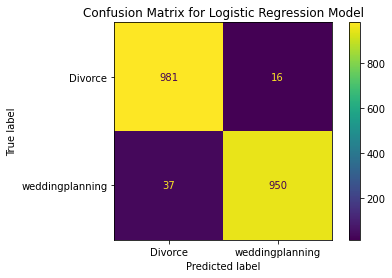

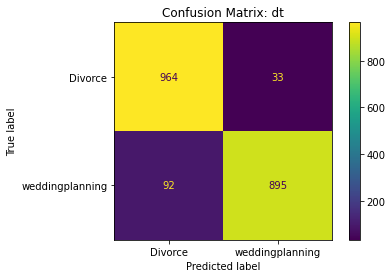

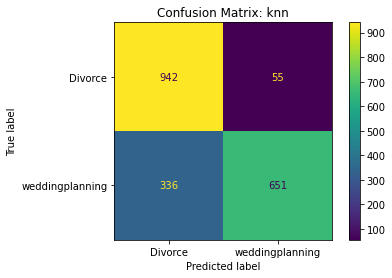

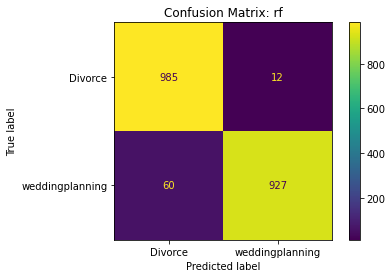

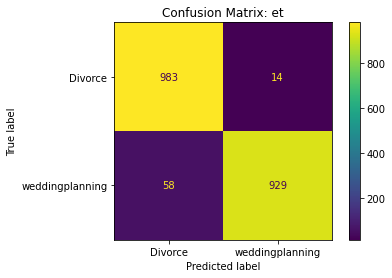

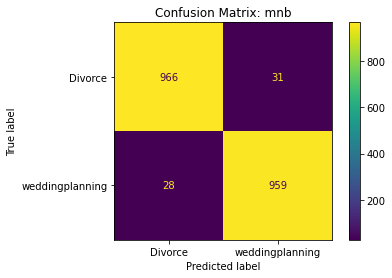

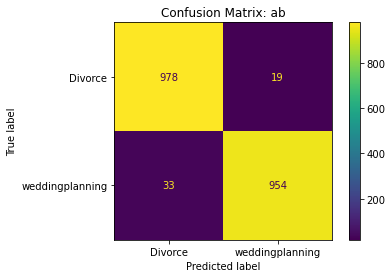

In [34]:
def confusion(pipe):
    ConfusionMatrixDisplay.from_estimator(pipe,X_test,y_test)
    plt.title(f'Confusion Matrix: {list(pipe.named_steps.keys())[1]}');

for pipe in pipelines:
    confusion(pipe);
    if pipe == pipe_lr:
        plt.title('Confusion Matrix for Logistic Regression Model')
        plt.savefig('../images/confusion matrix lr',bbox_inches='tight')

In [35]:
misclassifications= X_test.copy()

In [36]:
misclassifications['true class'] = y_test

In [37]:
misclassifications['LR pred class'] = pipe_lr.predict(X_test)
misclassifications['DT pred class'] = pipe_dt.predict(X_test)
misclassifications['KNN pred class'] = pipe_knn.predict(X_test)
misclassifications['RF pred class'] = pipe_rf.predict(X_test)
misclassifications['ET pred class'] = pipe_et.predict(X_test)
misclassifications['MNB pred class'] = pipe_mnb.predict(X_test)
misclassifications['AB pred class'] = pipe_ab.predict(X_test)

In [38]:
df[['selftext','title']].iloc[7369,:][1]

'Can you give me a checklist of red flags to look out for ? Both during and before you get with a person..'

In [39]:
misclassifications[misclassifications['true class'] != misclassifications['LR pred class']]

,selftext,title,true class,LR pred class,DT pred class,KNN pred class,RF pred class,ET pred class,MNB pred class,AB pred class
3778,[removed],Am I in the Wrong?,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning,Divorce
7369,"Going through something super unexpected, and ...",Can you give me a checklist of red flags to lo...,Divorce,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning
2448,"I feel uncomfortable with being called a ""wife...","Anyone else not want to be referred to as ""wife""?",weddingplanning,Divorce,Divorce,weddingplanning,Divorce,Divorce,weddingplanning,Divorce
428,[removed],No videographer,weddingplanning,Divorce,Divorce,Divorce,Divorce,Divorce,weddingplanning,weddingplanning
508,[removed],Filing Question,weddingplanning,Divorce,Divorce,Divorce,Divorce,Divorce,Divorce,Divorce
4343,[removed],My internet friends please read my post,Divorce,weddingplanning,Divorce,Divorce,Divorce,Divorce,weddingplanning,weddingplanning
6249,[removed],How nervous should I (26f) be about her (24f) ...,Divorce,weddingplanning,Divorce,Divorce,Divorce,Divorce,Divorce,weddingplanning
6734,[removed],Other options?,Divorce,weddingplanning,Divorce,Divorce,Divorce,Divorce,weddingplanning,weddingplanning
4108,"Never, ever use this rip off service. Somehow...",COMPLETECASE.com,Divorce,weddingplanning,weddingplanning,Divorce,Divorce,Divorce,Divorce,Divorce
1506,"To start, I'm not engaged currently (Although ...",How are you guys paying for it on top of every...,weddingplanning,Divorce,weddingplanning,Divorce,weddingplanning,Divorce,weddingplanning,Divorce


It seems that some of the classifications could go the other way depending on the model used. Let's try a voting classifier to improve model performance.

### Voting Classifier

In [40]:
# lr train score is 0.9954614220877458 and test score is 0.9732862903225806
# dt train score is 0.9939485627836612 and test score is 0.9369959677419355
# knn train score is 0.9515885022692889 and test score is 0.8029233870967742
# rf train score is 0.9978147587829888 and test score is 0.9637096774193549
# et train score is 0.9978147587829888 and test score is 0.9637096774193549
# mnb train score is 0.9828542612203732 and test score is 0.9702620967741935
# ab train score is 0.9910909396537233 and test score is 0.9737903225806451

In [41]:
pipelines_names = list(zip(['lr','dt','knn','rf','et','mnb','ab'],pipelines))

In [42]:
vr1 = VotingClassifier(
    pipelines_names,
    n_jobs=-1,
    weights=[1,0,0,0,1,0,1],
    voting='soft'
)
vr1.fit(X_train,y_train);

In [43]:
vr1.score(X_train,y_train), vr1.score(X_test,y_test)


(0.9978147587829888, 0.9737903225806451)

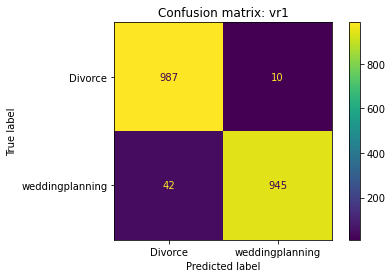

In [44]:
ConfusionMatrixDisplay.from_estimator(vr1,X_test,y_test)
plt.title('Confusion matrix: vr1');

Manual changing of weights & voting (pre-optimization of ada-boost):
- test score: 0.97177 for weights = [1,1,1,1,1,1,1] and voting='hard'
- test score: 0.97429 for weights = [1,1,1,1,1,1,1] and voting='soft'
- test score: 0.97782 for weights=[2,1,0.5,1.5,1.5,1.5,2],
    voting='soft'
- test score: 0.97379 for weights=[2,1,0.5,1.5,1.5,1.5,2],
    voting='hard'
- test score: 0.97278 for weights=[1,0,0,0,1,0,1],
    voting='hard'
- test score: 0.97429 for weights=[1,0,0,0,1,0,1],
    voting='soft'
- test score: 0.97328 for weights=[1,0,0,1,0,0,1],
    voting='soft'
- test score: 0.96471 weights=[0,0,0,1,0,0,1],
    voting='soft'
- test score: 0.96421 weights=[0,0,0,0,1,0,1],
    voting='soft'
- test score: 0.97429 weights=[0,0,0,1,0,1,1],
    voting='soft'

In [45]:
vr2 = VotingClassifier(
    pipelines_names,
    n_jobs=-1,
    weights=[1,0,0,1,0,0,1],
    voting='soft'
)
vr2.fit(X_train,y_train);

In [46]:
vr2.score(X_train,y_train), vr2.score(X_test,y_test)


(0.9974785678265254, 0.9727822580645161)

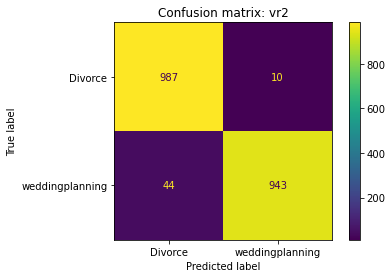

In [47]:
ConfusionMatrixDisplay.from_estimator(vr2,X_test,y_test)
plt.title('Confusion matrix: vr2');

In [48]:
vr3 = VotingClassifier(
    pipelines_names,
    n_jobs=-1,
    weights=[2,1,0.5,1.5,1.5,1.5,2],
    voting='soft'
)
vr3.fit(X_train,y_train);

In [49]:
vr3.score(X_train,y_train), vr3.score(X_test,y_test)


(0.9974785678265254, 0.9783266129032258)

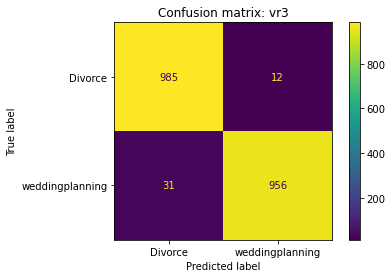

In [58]:
ConfusionMatrixDisplay.from_estimator(vr3,X_test,y_test)
plt.title('Confusion matrix: vr3');

#### Recall

After consulting my client, the divorce lawyer, with the potential models, she advised me that she is happy with all of the accuracies, and would rather have a model that potentially advertises to more divorcees at the expense of advertising to more wedding planners.

In data science terms, this means that among these models, I would like to maximize the recall (where the positive class label is set to Divorce).

Comparing the voting classifier confusion matrices, those that best maximized specificity were:
- weights=[1,0,0,0,1,0,1], voting='soft'
- weights=[1,0,0,1,0,0,1], voting='soft'

Additionally, there was a model that used all models at different weights, and it had the highest accuracy, but lower specificity than vr1 and vr2.

In [51]:
for pipe in pipelines:
    print(f'{list(pipe.named_steps.keys())[1]} recall score is {recall_score(y_test,pipe.predict(X_test),pos_label="Divorce")}')
print(f'vr1 recall score is {recall_score(y_test,vr1.predict(X_test),pos_label="Divorce")}')
print(f'vr2 recall score is {recall_score(y_test,vr2.predict(X_test),pos_label="Divorce")}')
print(f'vr3 recall score is {recall_score(y_test,vr3.predict(X_test),pos_label="Divorce")}')

lr recall score is 0.9839518555667001
dt recall score is 0.966900702106319
knn recall score is 0.9448345035105316
rf recall score is 0.9879638916750251
et recall score is 0.9859578736208626
mnb recall score is 0.9689067201604814
ab recall score is 0.9809428284854563
vr1 recall score is 0.9899699097291875
vr2 recall score is 0.9899699097291875
vr3 recall score is 0.9879638916750251


Among these models, rf, vr1, and vr2 maximized the specificity (reminder, where divorce is negative class).

In [52]:
print(f'rf test accuracy is {pipe_rf.score(X_test,y_test)}')
print(f'vr1 test accuracy is {vr1.score(X_test,y_test)}')
print(f'vr2 test accuracy is {vr2.score(X_test,y_test)}')

rf test accuracy is 0.9637096774193549
vr1 test accuracy is 0.9737903225806451
vr2 test accuracy is 0.9727822580645161


Between these three models, I will choose to use vr1 for the production model because it has among the highest accuracy scores and maximizes specificity. VR1 uses a equal weight and soft voting method of combining the logistic regression, random forest classifier, and ada boost classifiers.

In [53]:
%store vr1

Stored 'vr1' (VotingClassifier)


In [54]:
misclassifications['vr1 pred class'] = vr1.predict(X_test)

In [55]:
misclassifications[(misclassifications['true class'] != misclassifications['vr1 pred class']) & (misclassifications['true class'] == 'Divorce')]   

,selftext,title,true class,LR pred class,DT pred class,KNN pred class,RF pred class,ET pred class,MNB pred class,AB pred class,vr1 pred class
7369,"Going through something super unexpected, and ...",Can you give me a checklist of red flags to lo...,Divorce,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
6459,"SOCK DAY 21/03/2022, 3PM.\nIt's nearly time!",NINE days and counting,Divorce,Divorce,Divorce,weddingplanning,weddingplanning,weddingplanning,Divorce,weddingplanning,weddingplanning
4600,[removed],Dads how often do you talk to your kids? its r...,Divorce,Divorce,Divorce,weddingplanning,weddingplanning,weddingplanning,Divorce,Divorce,weddingplanning
4321,Those who have went threw the Discovery proces...,Discovery process Photos,Divorce,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
4023,how long do I have time wise to reply back?,I live in Ohio and we're supposed to use famil...,Divorce,weddingplanning,Divorce,Divorce,Divorce,weddingplanning,weddingplanning,Divorce,weddingplanning
5653,I hate my maiden name because my dad abandoned...,Name Change,Divorce,weddingplanning,weddingplanning,Divorce,weddingplanning,weddingplanning,Divorce,weddingplanning,weddingplanning
5103,[removed],Bit of a rant about Beta/alpha,Divorce,weddingplanning,weddingplanning,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
6341,"I have my band and engagement ring to sell, th...",Has anyone used Worthy to sell their rings?,Divorce,weddingplanning,weddingplanning,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
5635,[removed],any companies that will help consolidate my cr...,Divorce,weddingplanning,weddingplanning,Divorce,Divorce,Divorce,Divorce,weddingplanning,weddingplanning
6485,[removed],"how it began, ended, and the unknowable future",Divorce,weddingplanning,weddingplanning,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning


Save misclassifications for later analysis

In [56]:
misclassifications.to_csv('../datasets/misclassifications.csv',index=False)

In [57]:
misclassifications[(misclassifications['selftext'].str.contains('divorce')) & (misclassifications['true class']=='weddingplanning')]

,selftext,title,true class,LR pred class,DT pred class,KNN pred class,RF pred class,ET pred class,MNB pred class,AB pred class,vr1 pred class
3208,I know I know I know I know I don’t *have* to ...,Minor detail: I’m struggling with the whole na...,weddingplanning,weddingplanning,weddingplanning,Divorce,Divorce,Divorce,Divorce,weddingplanning,Divorce
77,Hi all! I am a first-time poster but a long-ti...,Father/daughter dance alternative options?,weddingplanning,weddingplanning,weddingplanning,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning,weddingplanning
2635,I'd love to hear how other people handled situ...,How did you/are you planning on handling any a...,weddingplanning,weddingplanning,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
3631,I just bought a bunch of photo frames at Goodw...,what photos are typically displayed at weddings?,weddingplanning,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
2195,TLDR/BLUF: Do I contribute what I'm most comf...,Seeking input re my contribution (I'm the groo...,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
1088,My husband (we are already legally married) ha...,Step mother in law. Should she wear a MOG dres...,weddingplanning,Divorce,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning,Divorce,Divorce
2518,"Hi weddit,\n\nI'm looking for some advice on c...",Collecting wedding shower RSVPs when parents a...,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
2700,I’ll try to keep this short. My fiancé wants b...,My mom is siding with my fiancé about spending...,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning,weddingplanning
3376,Alright weddit!! 6 weeks out and working to fi...,Who did your parents and in-laws walk down the...,weddingplanning,weddingplanning,Divorce,weddingplanning,Divorce,weddingplanning,weddingplanning,weddingplanning,weddingplanning
2093,I got engaged in October 2019... Covid hit and...,advice for a bride with a tense parental situa...,weddingplanning,weddingplanning,weddingplanning,weddingplanning,Divorce,Divorce,weddingplanning,weddingplanning,weddingplanning
